# Imports

In [1]:
# importanto as bibliotecas
import numpy as np
from numpy import mean
from scipy import stats
import math
import pandas as pd
#import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from scipy import stats
from datetime import date, time, datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA, AutoETS, HoltWinters
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation # validação de métricas
from prophet.diagnostics import performance_metrics # validação de métricas

sns.set_theme(style="whitegrid", palette="pastel")

C:\Users\brcalazans\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\core.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Helper Functions

In [2]:
def correct_value_with_separators(row):
    value = row['Preco']
    before_dot = str(value)[:-2]
    after_dot = str(value)[-2:]
    new_value = before_dot + "." + after_dot
    return new_value

In [3]:
dias_da_semana = {
    0: "Segunda-Feira",
    1: "Terça-Feira",
    2: "Quarta-Feira",
    3: "Quinta-Feira",
    4: "Sexta-Feira",
    5: "Sábado",
    6: "Domingo"
}

## Database

In [35]:
ipeadata = pd.read_html(r"http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view", encoding='utf-8', header=0)[2]

# Análise Exploratória de Dados

In [5]:
ipeadata.head()

,Data,Preço - petróleo bruto - Brent (FOB)
0,26/12/2023,8023
1,22/12/2023,8023
2,21/12/2023,8073
3,20/12/2023,8110
4,19/12/2023,7982


In [6]:
ipeadata.shape

(11074, 2)

In [7]:
ipeadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11074 entries, 0 to 11073
Data columns (total 2 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Data                                  11074 non-null  object
 1   Preço - petróleo bruto - Brent (FOB)  11074 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 173.2+ KB


In [8]:
ipeadata.describe()

,Preço - petróleo bruto - Brent (FOB)
count,11074.000000
mean,5275.403558
std,3324.041520
min,910.000000
25%,2038.500000
50%,4780.500000
75%,7554.750000
max,14395.000000


In [9]:
ipeadata.isna().sum()

Data                                    0
Preço - petróleo bruto - Brent (FOB)    0
dtype: int64

# Tratamento dos Dados

## Renomeando as Colunas

In [10]:
ipeadata.columns

Index(['Data', 'Preço - petróleo bruto - Brent (FOB)'], dtype='object')

In [11]:
ipeadata.columns = ['Data', 'Preco']

## Alterando os tipos das variáveis

In [12]:
ipeadata.Data = pd.to_datetime(ipeadata.Data)

C:\Users\brcalazans\AppData\Local\Temp\ipykernel_48496\3984196406.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  ipeadata.Data = pd.to_datetime(ipeadata.Data)


In [13]:
ipeadata.Preco = ipeadata.apply(lambda row: correct_value_with_separators(row), axis=1)

In [14]:
ipeadata.head()

,Data,Preco
0,2023-12-26,80.23
1,2023-12-22,80.23
2,2023-12-21,80.73
3,2023-12-20,81.10
4,2023-12-19,79.82


In [15]:
ipeadata.Preco = ipeadata.Preco.astype(float)

## Transformação dos Dados

In [16]:
ipeadata['Dia da semana'] = ipeadata.Data.dt.dayofweek

In [17]:
ipeadata['Dia da semana'] = ipeadata['Dia da semana'].map(dias_da_semana)

In [18]:
# Redefinindo o Index
ipeadata = ipeadata.set_index('Data')

In [19]:
ipeadata.head()

,Preco,Dia da semana
Data,,
2023-12-26,80.23,Terça-Feira
2023-12-22,80.23,Sexta-Feira
2023-12-21,80.73,Quinta-Feira
2023-12-20,81.10,Quarta-Feira
2023-12-19,79.82,Terça-Feira


# Visualização de Dados

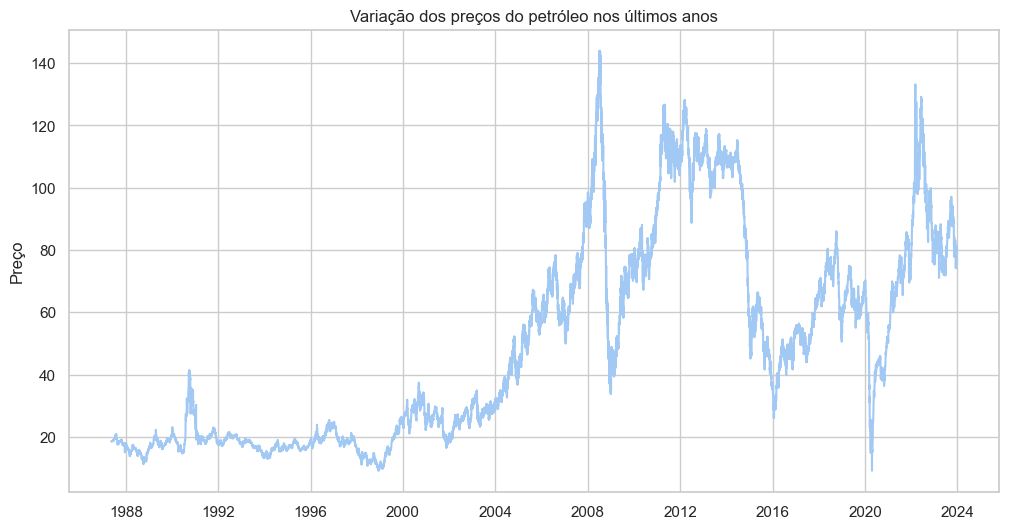

In [20]:
plt.figure(figsize=(12,6))
sns.lineplot(data=ipeadata, x='Data', y='Preco')
plt.xlabel("")
plt.ylabel("Preço")
plt.title("Variação dos preços do petróleo nos últimos anos")
plt.show()

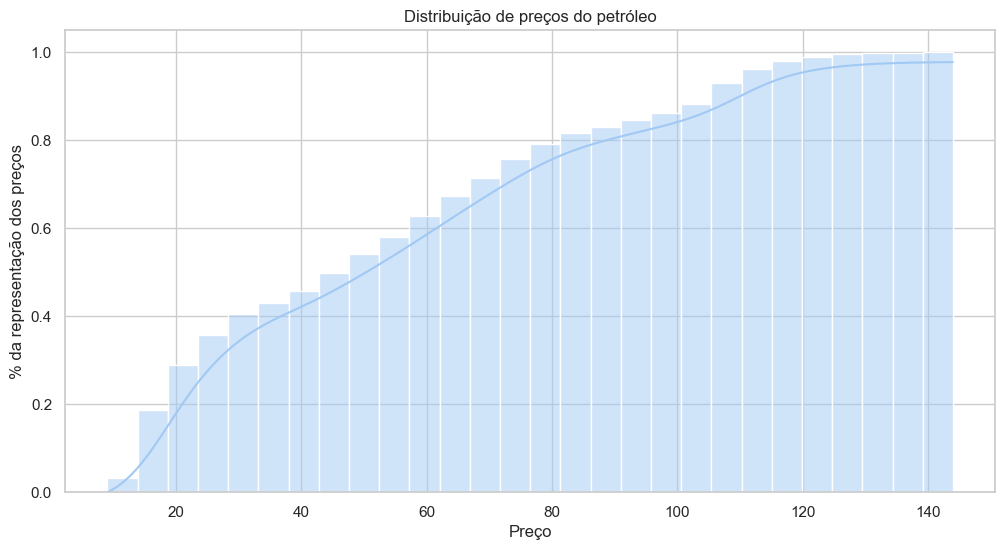

In [21]:
plt.figure(figsize=(12,6))

sns.histplot(data=ipeadata, x='Preco', cumulative=True, stat='density', kde=True)
plt.title("Distribuição de preços do petróleo")
plt.xlabel("Preço")
plt.ylabel("% da representação dos preços")
plt.show()

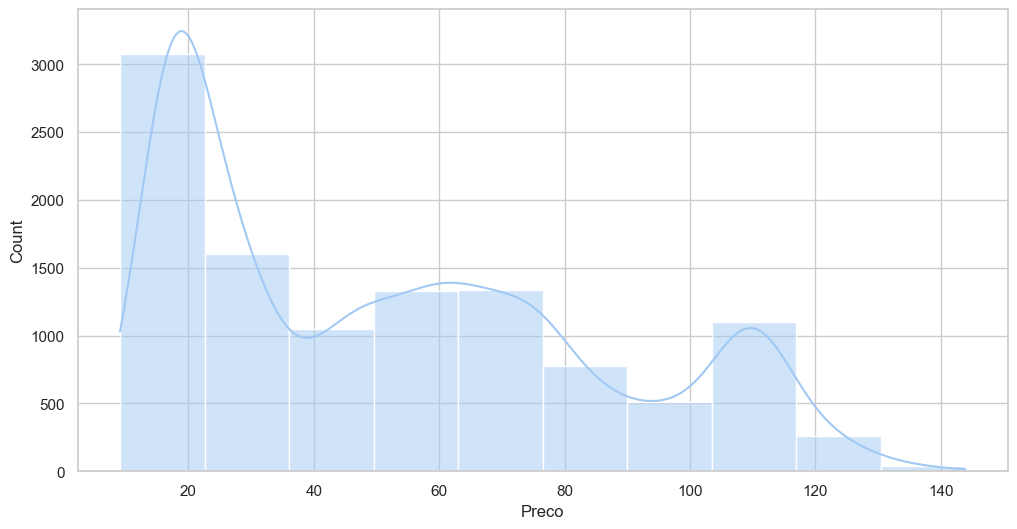

In [22]:
plt.figure(figsize=(12,6))
sns.histplot(ipeadata['Preco'], bins=10, kde=True)
plt.show()

In [23]:
print(f"Média: {round(np.average(ipeadata['Preco']), 2)}")
print(f"Moda: {stats.mode(ipeadata['Preco'])[0]}")
print(f"Mediana: {np.median(ipeadata['Preco'])}")

Média: 52.75
Moda: 18.48
Mediana: 47.805


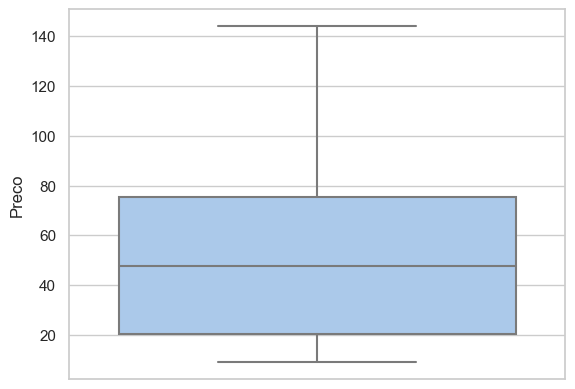

In [24]:
sns.boxplot(y=ipeadata['Preco'])
plt.show()

### Teste Shapiro Wilk

In [25]:
shapiro_test = stats.shapiro(ipeadata['Preco'])
shapiro_test


# Conforme avaliamos, nós não temos uma distribuição normal

C:\Users\brcalazans\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9094343185424805, pvalue=0.0)

In [26]:
ipeadata.groupby("Dia da semana").nunique()

,Preco
Dia da semana,
Domingo,791
Quarta-Feira,1543
Quinta-Feira,1524
Segunda-Feira,1524
Sexta-Feira,1543
Sábado,845
Terça-Feira,1537


In [27]:
dia_da_semana_agrupado = ipeadata.groupby("Dia da semana").nunique()
#dia_da_semana_agrupado = dia_da_semana_agrupado.sort_values(ascending=True)

In [28]:
for idx, value in enumerate(dia_da_semana_agrupado.values):
    print(idx)

0
1
2
3
4
5
6


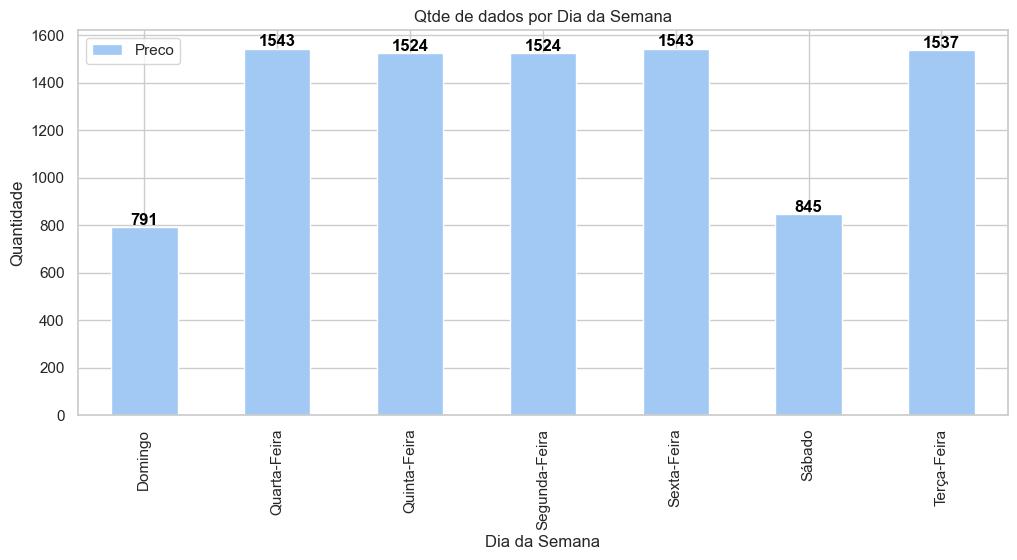

In [29]:
ax = dia_da_semana_agrupado.plot(kind='bar', figsize=(12,5))
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade')
plt.title('Qtde de dados por Dia da Semana')

# Adicionar valores como anotações nas barras
for idx, value in enumerate(dia_da_semana_agrupado.values):
    ax.text(idx, value + 10, str(value[0]), ha='center', color='black', fontweight='bold')

plt.show()

## Análise do Seasonal Decompose

In [30]:
resultado_seasonal_decompose = seasonal_decompose(ipeadata[['Preco']], period=12, model='multiplicative')

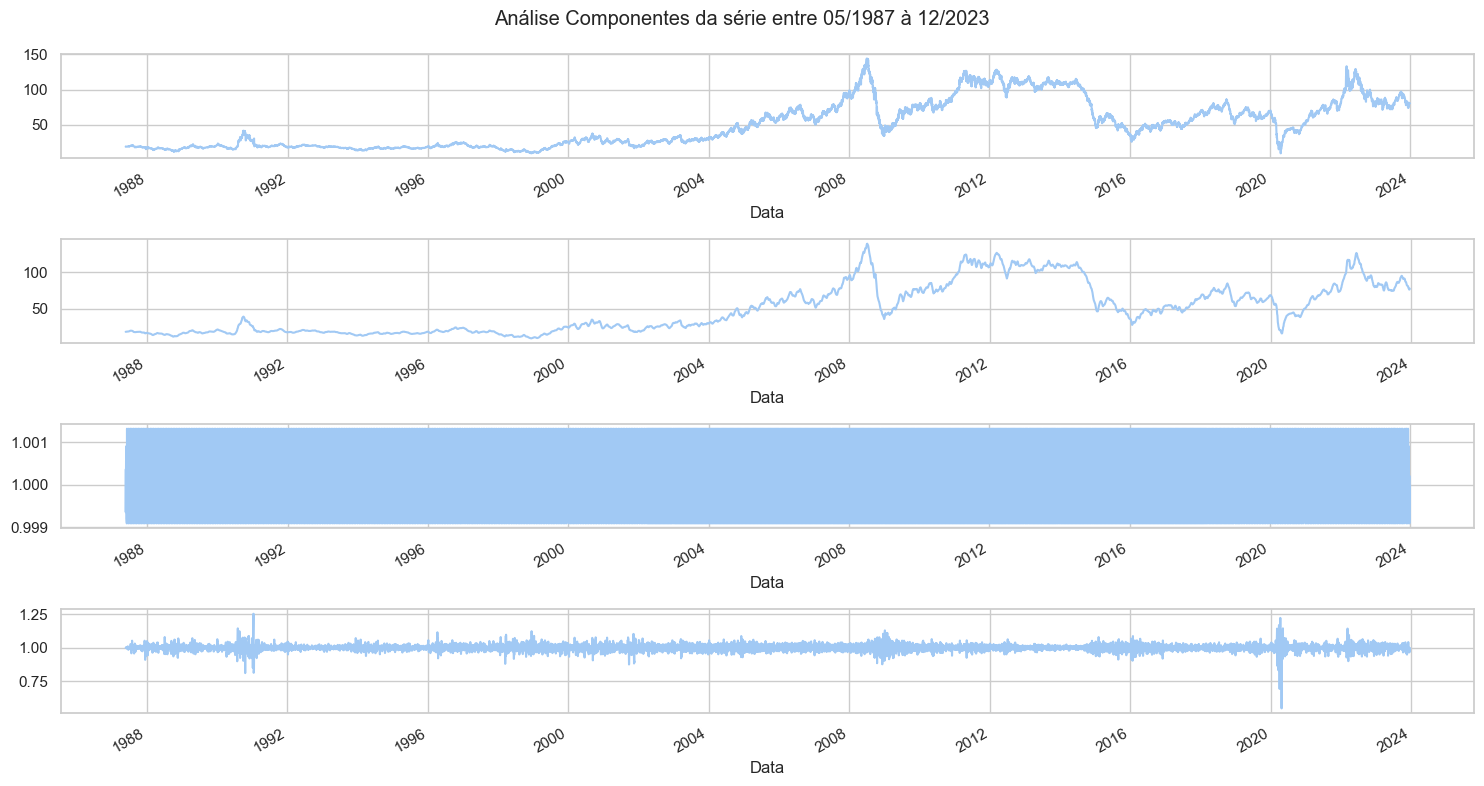

In [31]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=(15,8))
plt.suptitle("Análise Componentes da série entre 05/1987 à 12/2023")
resultado_seasonal_decompose.observed.plot(ax=ax1) # observação dos gráficos ao longo do tempo
resultado_seasonal_decompose.trend.plot(ax=ax2) # tendência dos dados ao longo do tempo
resultado_seasonal_decompose.seasonal.plot(ax=ax3) # sazonalidade / recorrencia dos dados
resultado_seasonal_decompose.resid.plot(ax=ax4) # residuos que não necessariamente fazem sentido - IMPORTANTE AVALIAR

plt.tight_layout()
plt.show()

In [33]:
resultado_seasonal_decompose.resid.to_frame().mean()

resid    0.999748
dtype: float64